### 3. Modelling

In [1]:
!pip install tf-keras-nightly

In [2]:
import os
import numpy as np
import random
import shutil
import time
import zipfile
import PIL
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import dump,load
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report

In [17]:
# Function to plot loss and accuracy metrics vs number of epochs with train and validation sets

def visualize_training_results(results, img_name):
    history = results.history

    start_epoch = 0
    epoch_count = len(history['accuracy']) + start_epoch
    epochs = []
    for i in range(start_epoch, epoch_count):
        epochs.append(i+1)

    # Obtaining the epoch with the lowest validation loss
    index_loss = np.argmin(history['val_loss'])
    val_lowest = history['val_loss'][index_loss]

    # Obtaining the epoch with the highest validation accuracy
    index_acc = np.argmax(history['val_accuracy'])
    acc_highest = history['val_accuracy'][index_acc]

    # Best epoch labels:
    epoch_loss_label = 'best epoch= '+ str(index_loss+1 +start_epoch)
    epoch_acc_label =  'best epoch= '+ str(index_acc + 1+ start_epoch)

    # setting the style to be used
    plt.style.use('fivethirtyeight')

    # create two axis objects side by side
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))

    # plot loss on the first axis
    ax1.plot(history['val_loss'], color='r', label='Validation loss')
    ax1.plot(history['loss'], color='g', label='Training loss')
    ax1.scatter(index_loss+1 +start_epoch,val_lowest, c= 'blue', s=100, label=epoch_loss_label)
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

      # plot recall and f1 score metrics on the second axis
    ax2.plot(history['val_accuracy'], color='r', label= 'Validation Accuracy')
    ax2.plot(history['accuracy'], color='g',label= 'Training Accuracy')
    ax2.scatter(index_acc+1 +start_epoch, acc_highest, c='blue', s=100,  label=epoch_acc_label)
    ax2.legend()
    ax2.set_title('Traing and Validation  Accuracy score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig('./results/'+img_name)

In [4]:
# Define the batch size and number of epochs for training
batch_size = 32
epochs = 10
# Define the input shape of the images (300 was choosen so that we can be able to use EfficientNetB2 model later on)
input_shape = (300, 300, 3)

### Model 2 (VGG16) : Training and Validation

In [5]:
# Create an instance of ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dir = 'cleaned_images/train'
validation_dir = 'cleaned_images/validation'
test_dir = 'cleaned_images/test'

In [7]:
# Create generators for loading the train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 1290 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [8]:
# Load the pre-trained VGG16 model (excluding the top layers)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [9]:
# Freeze the weights of the pre-trained layers
for layer in vgg16_model.layers:
    layer.trainable = False
    
# Add a new classifier on top of the pre-trained layers
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [10]:
# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
full_name = 'VGG16'
filepath="models/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name  # Path to save the trained models
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

In [12]:
# Train the model using the train and validation generators
VGG16_model = model.fit(train_generator,
                        steps_per_epoch=16,
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=callbacks_list)

Epoch 1/10
16/16 [==============================] - 256s 16s/step - loss: 8.4065 - accuracy: 0.3332 - val_loss: 2.5501 - val_accuracy: 0.4286
Epoch 2/10
16/16 [==============================] - 369s 23s/step - loss: 2.0427 - accuracy: 0.5258 - val_loss: 0.6602 - val_accuracy: 0.6894
Epoch 3/10
16/16 [==============================] - 384s 24s/step - loss: 0.8041 - accuracy: 0.6274 - val_loss: 0.6300 - val_accuracy: 0.6957
Epoch 4/10
16/16 [==============================] - 365s 23s/step - loss: 0.6314 - accuracy: 0.6738 - val_loss: 0.5324 - val_accuracy: 0.7019
Epoch 5/10
16/16 [==============================] - 369s 23s/step - loss: 0.5651 - accuracy: 0.6974 - val_loss: 0.5257 - val_accuracy: 0.7019
Epoch 6/10
16/16 [==============================] - 365s 23s/step - loss: 0.5195 - accuracy: 0.7528 - val_loss: 0.5079 - val_accuracy: 0.7143
Epoch 7/10
16/16 [==============================] - 377s 24s/step - loss: 0.4686 - accuracy: 0.7969 - val_loss: 0.4822 - val_accuracy: 0.7143
Epoch 

### Testing Accuracy for Testing Data

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

6/6 [==============================] - 109s 17s/step - loss: 0.4379 - accuracy: 0.8137
Test accuracy: 0.8136646151542664


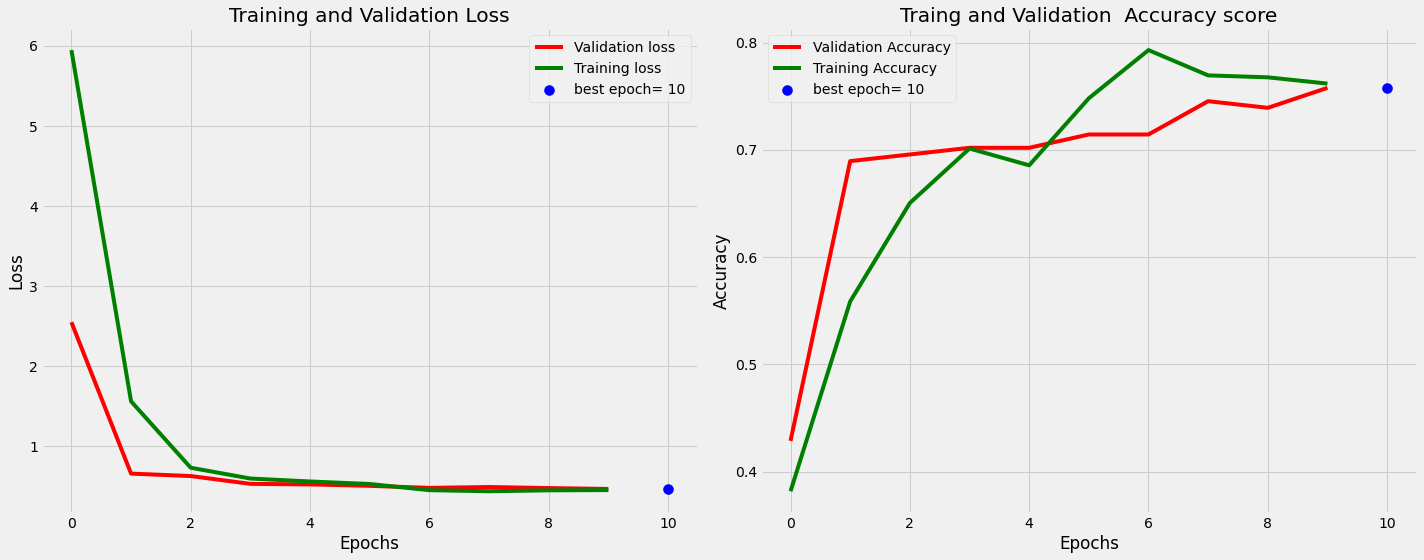

In [18]:
visualize_training_results(VGG16_model, "VGG16_Model.png")